In [1]:
data_files = [
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339089.nxs',
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339090.nxs',
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339091.nxs',
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339092.nxs',
]

sim_data = {
    'ion': 'Cu',  # Ion Name
    'ch': 2,  # Charge
    'beta': 0.8,  # Beta
    'dq': 1.0,  # 10Dq
    'mag_field': (0, 0, 0),
    'exchange_field': (0, 0, 0.1),
    'temperature': 1.0,  # T (K)
    'detector_name': None,
}

# XAS Simulation Comparison
### Using Quanty

In [2]:
%matplotlib ipympl
%autosave 60

#! module load quanty  # specifies the Quanty location (doesn't work!)
#! python -m pip install --upgrade hdfmap

import os
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, Markdown, Latex

from xas_simulator.simulation import create_simulation
from xas_simulator.beamline_data_loader import display_scans, get_scan_paths, Experiment
# from xas_simulator.xmcd_analysis import calculate_xmcd, compare_spectra
from xas_simulator.spectra_analysis import get_spectra, fit_bkg_then_norm_to_jump, fit_bkg_then_norm_to_peak, calc_subtraction

import hdfmap
hdfmap.set_all_logging_level('error')

Autosaving every 60 seconds
Writable TEMPDIR = /tmp


# Load and Analyse Experiment Data

In [3]:
print('--- I06-1 Data ---')
print(display_scans(data_files))


--- I06-1 Data ---
i06-1-339089.nxs pol=pc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1
i06-1-339090.nxs pol=pc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1
i06-1-339091.nxs pol=nc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1
i06-1-339092.nxs pol=nc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1


In [4]:
# Analyse data
signal_name = sim_data['detector_name']  # default=None, or set to e.g. 'C1'
energy_path, signal_path, monitor_path, pol_path = get_scan_paths(data_files[0], signal_name)

signal_name = signal_name or signal_path

# load data, average and normalise spectra
av_energy, signals, raw = get_spectra(
    *data_files,
    energy_path=energy_path,
    signal_path=signal_path,
    pol_path=pol_path,
    monitor_path=monitor_path
)

# normalise spectra and remove background (normalise high energy region to 1)
norm_signals = {
    #label: fit_bkg_then_norm_to_peak(
    label: fit_bkg_then_norm_to_jump(
        energy=av_energy, 
        signal=signal, 
        ev_from_start=6,  # defines background region below edge, in eV from start of scan
        ev_from_end=10  # defines high-energy region above edge, in eV from end of scan
    )[0] for label, signal in signals.items()
}

# determine polarisations and calculate subtraction (XMCD or XMLD)
result, subtraction_type = calc_subtraction(norm_signals)
print(f"Analysing {subtraction_type}")

Analysing XMCD


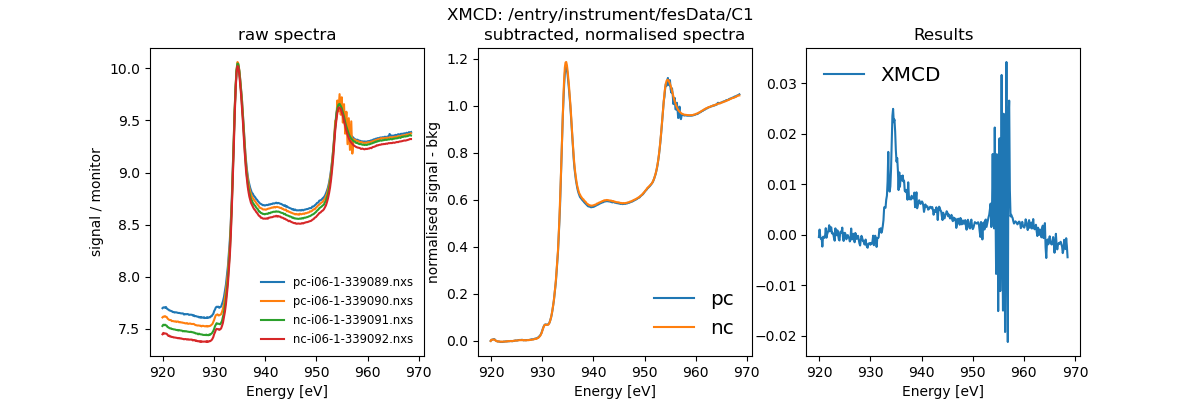

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle(f"{subtraction_type.upper()}: {signal_name}")

for pol, data in raw.items():
    for name, (energy, sig) in data.items():
        ax[0].plot(energy, sig, '-', label=f"{pol}-{name}")
ax[0].set_xlabel('Energy [eV]')
ax[0].set_ylabel('signal / monitor')
ax[0].set_title('raw spectra')
ax[0].legend(fontsize='small', frameon=False)

for label, sig in norm_signals.items():
    ax[1].plot(av_energy, sig, '-', label=label)
ax[1].set_xlabel('Energy [eV]')
ax[1].set_ylabel('normalised signal - bkg')
ax[1].set_title('subtracted, normalised spectra')
ax[1].legend(fontsize='x-large', frameon=False)

ax[2].plot(av_energy, result, '-', label=subtraction_type)
ax[2].set_xlabel('Energy [eV]')
ax[2].set_title('Results')
ax[2].legend(fontsize='x-large', frameon=False)

In [7]:
# Create and run Quanty Simulation
detector = sim_data.pop('detector_name')
simulation = create_simulation(**sim_data)
output = simulation.run_all_with_output()
print(simulation.result.stdout)

3d9 2p5,3d10
====    written by Maurits W. Haverkort,                 ====
====    Yi Lu, Robert Green, Sebastian Macke,            ====
====    Marius Retegan, Martin Brass, Simon Heinze,      ====
====    Charles Cardot, Michelangelo Tagliavini,         ====
====    Sina Shokri, Kai Arnold, Paul Hill,              ====
====    Kevin Ackermann, Aleksandrs Zacinskis            ====
====    (cc) 1995 - 2024 code and binaries released      ====
====    under creative commons CC-BY lisence             ====
====    www.quanty.org                                   ====
====    Beta version, be critical and report errors!!!   ====
====    Version 0.8 beta                                 ====
====            compiled at: Sep 20 2024 at 08:25:23     ====
====    When used in scientific publications please cite ====
====    one of the following papers as appropriate with  ====
====    respect to the methods used in your publication: ====
====    Phys. Rev. B 85, 165113 (2012)                   

1025 1025
Theoretical values (Quanty):


L$_z$,T$_{z}$,S$_{z}$,S$_{eff}$
-0.3758,-0.2521,-0.4963,-0.7484


Sum rules :


sL$_z$,sS$_{eff}$
0.282943,-1.0208


Sum rules 0:


s$_0$L$_z$,s$_0$S$_{eff}$
0.251622,-0.907799


Deviations:


$\Delta$XAS (%),$\Delta$L$_{z}$ (%),$\Delta$S$_{eff}$ (%),$\Delta_0$L$_{z}$ (%),$\Delta_0$S$_{eff}$ (%)
24.8956,-24.7091,36.3977,-33.0437,21.2987


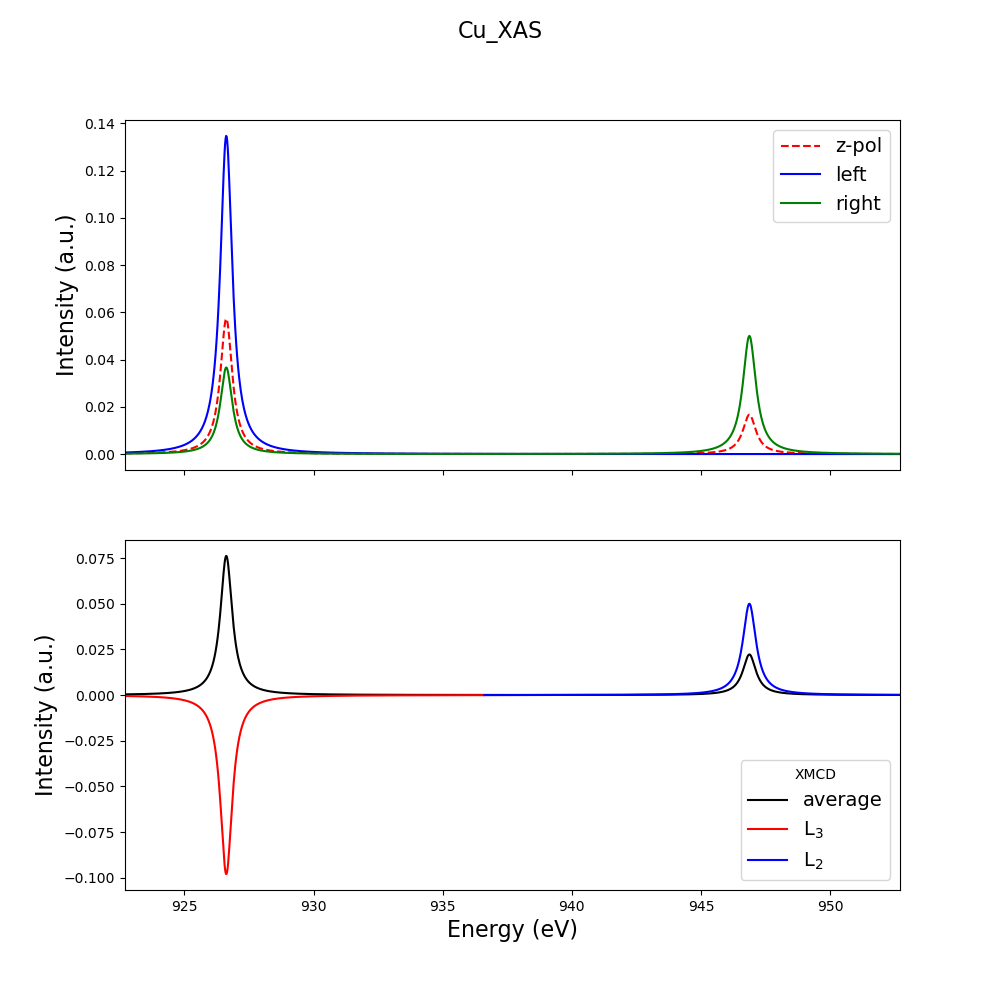

In [8]:
simulation.post_proc()

In [9]:
# Guess offset
simulation_max = output['xas_left_energy'][np.argmax(output['xas_left'])]
experiment_max = av_energy[np.argmax(next(iter(signals.values())))]
ini_offset = experiment_max - simulation_max
print(f"Offset = {ini_offset:.2f} eV")

Offset = 8.07 eV


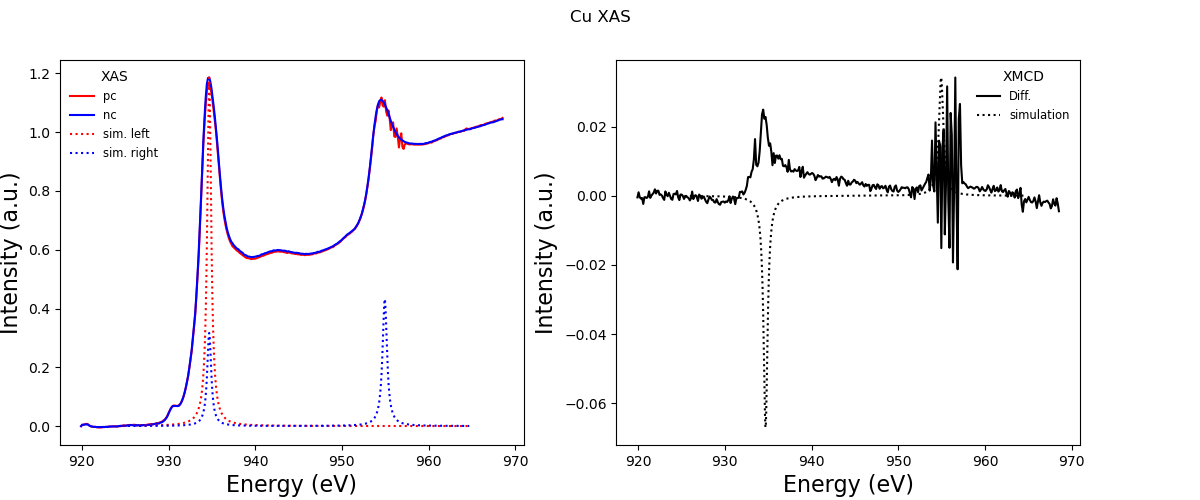

In [10]:
# Plot Comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
fig.subplots_adjust(left=0.05)
fig.suptitle(f"{simulation.ion} XAS")

left = output['xas_left'] * max(norm_signals['nc']) / max(output['xas_left'])
right = output['xas_right'] * max(norm_signals['pc']) / max(output['xas_left'])
xmcd = output['xmcd'] * max(result) / max(output['xmcd'])

ax[0].plot(av_energy, norm_signals['pc'], '-r', label='pc')
ax[0].plot(av_energy, norm_signals['nc'], '-b', label='nc')
ax[0].plot(output['xas_left_energy'] + ini_offset, left, ':r', label='sim. left')
ax[0].plot(output['xas_right_energy'] + ini_offset, right, ':b', label='sim. right')
ax[0].legend(fontsize='small', title='XAS', frameon=False)
ax[0].set_ylabel('Intensity (a.u.)', fontsize=16)
ax[0].set_xlabel('Energy (eV)', fontsize=16)

ax[1].plot(av_energy, result, '-k', label='Diff.')
ax[1].plot(output['xmcd_energy'] + ini_offset, xmcd, ':k', label='simulation')
ax[1].legend(fontsize='small', title='XMCD', frameon=False)
ax[1].set_ylabel('Intensity (a.u.)', fontsize=16)
ax[1].set_xlabel('Energy (eV)', fontsize=16)

plt.show()

# Interactive Plots

In [11]:
def change_offset(offset=ini_offset, scale=1.0, flip=False):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
    fig.subplots_adjust(left=0.05)
    fig.suptitle(f"{simulation.ion} XAS")

    flip = -1 if flip else 1

    left = scale * output['xas_left'] * max(norm_signals['nc']) / max(output['xas_left'])
    right = scale * output['xas_right'] * max(norm_signals['pc']) / max(output['xas_left'])
    xmcd = flip * scale * output['xmcd'] * max(result) / max(output['xmcd'])
    
    ax[0].plot(av_energy, norm_signals['pc'], '-r', label='pc')
    ax[0].plot(av_energy, norm_signals['nc'], '-b', label='nc')
    ax[0].plot(output['xas_left_energy'] + offset, left, ':r', label='sim. left')
    ax[0].plot(output['xas_right_energy'] + offset, right, ':b', label='sim. right')
    ax[0].legend(fontsize='small', title='XAS', frameon=False)
    ax[0].set_ylabel('Intensity (a.u.)', fontsize=16)
    ax[0].set_xlabel('Energy (eV)', fontsize=16)
    
    ax[1].plot(av_energy, result, '-k', label='Diff.')
    ax[1].plot(output['xmcd_energy'] + offset, xmcd, ':k', label='simulation')
    ax[1].legend(fontsize='small', title='XMCD', frameon=False)
    ax[1].set_ylabel('Intensity (a.u.)', fontsize=16)
    ax[1].set_xlabel('Energy (eV)', fontsize=16)
    
    plt.show()


widgets.interact(change_offset, offset=(ini_offset - 10.0, ini_offset + 10.0), scale=(0.1, 10.0));

interactive(children=(FloatSlider(value=8.073141728437804, description='offset', max=18.073141728437804, min=-…

In [12]:
exp = Experiment(os.path.dirname(data_files[0]))
files = exp.all_files()
print(len(files))

1176


In [13]:
widgets.interact(exp.read_scan, filename=[os.path.basename(file) for file in data_files]);

interactive(children=(Dropdown(description='filename', options=('i06-1-339089.nxs', 'i06-1-339090.nxs', 'i06-1…